# Sylvera Technical Task - Geospatial Data Engineer

## Set up

In [1]:
from helper_functions import *

import geopandas as gpd
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rasterio.mask
from rasterio.plot import reshape_as_image, show, adjust_band
import seaborn as sns

In [2]:
data_path = "./data/"

## Task 1 - Clip rasters

#### Clip all tif files in data folder using the provided shape

In [3]:
files_to_clip = glob.glob(f"{data_path}????.tif")
shape_path = f"{data_path}AOI/AOI.shp"

for f in files_to_clip:
    clip_raster_to_shape(f, shape_path, data_path)


print(glob.glob(f"{data_path}????_clipped.tif"))

['./data/2018_clipped.tif', './data/2017_clipped.tif', './data/2020_clipped.tif', './data/2015_clipped.tif', './data/2019_clipped.tif', './data/2016_clipped.tif']


## Task 2 - Plot and save true color image for 2020

### Create RGB raster

In [4]:
create_true_colour_image(f"{data_path}2020_clipped.tif", data_path)

print(glob.glob(f"{data_path}*true_color_*.tif"))

['./data/2020_true_color_clipped.tif']


### Plot RGB raster

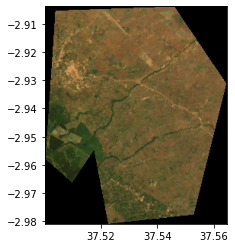

In [5]:
im = rio.open(f"{data_path}2020_true_color_clipped.tif").read()
rgb_im= adjust_band(im)
im = reshape_as_image(im)

transform = rio.open(f"{data_path}2020_true_color_clipped.tif").transform

fig, ax = plt.subplots(1)
show(rgb_im, ax=ax, transform=transform)

fig.savefig(f"{data_path}2020_true_color_clipped.png")


## Task 3 - Create and visualise NDVI time series

### Create time series data

In [6]:
src_files = glob.glob(f"{data_path}????_clipped.tif")
build_ndvi_time_series(src_files, data_path)

print(glob.glob(f"{data_path}ndvi*.csv"))

['./data/ndvi_mean_time_series.csv']


### Plot time series 

   year  ndvi_mean
0  2015   0.516438
1  2016   0.485951
2  2017   0.509476
3  2018   0.487584
4  2019   0.527874
5  2020   0.518203


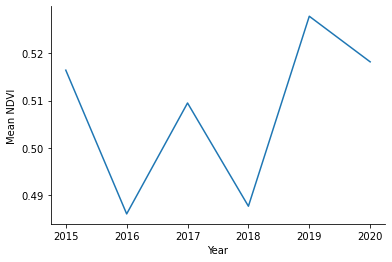

In [7]:
data = pd.read_csv(f"{data_path}ndvi_mean_time_series.csv", index_col=0)
print(data)

plot = sns.lineplot(data = data,
                    x = 'year',
                    y = 'ndvi_mean',
                    )

plot.set_xlabel('Year')
plot.set_ylabel('Mean NDVI')
sns.despine()

plot.get_figure().savefig(f"{data_path}mean_ndvi_time_series.png")

## Task 4 - Save NDVI time series CSV to AWS

In [8]:
%%script false --no-raise-error

## Section will fail as not actaully connecting to S3

# Set up session
AWS_S3_BUCKET = os.getenv("AWS_S3_BUCKET")
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
AWS_SESSION_TOKEN = os.getenv("AWS_SESSION_TOKEN")

# Read dataframe
ndvi_df = pd.read_csv("./data/ndvi_mean_time_series.csv", index_col=0)
key = "files/ndvi_time_series.csv"

# Save to S3
ndvi_df.to_csv(
    f"s3://{AWS_S3_BUCKET}/{key}",
    index=False,
    storage_options={
        "key": AWS_ACCESS_KEY_ID,
        "secret": AWS_SECRET_ACCESS_KEY,
        "token": AWS_SESSION_TOKEN,
    },
)

## Task 5 - Create time series raster for RED Channel

In [9]:
src_files = glob.glob(f"{data_path}????_clipped.tif")
build_RED_time_series_raster(src_files, data_path)

print(glob.glob(f"{data_path}RED*.tif"))

['./data/RED_timeseries.tif']


## Task 6 - Calculate total area of clipped raster

### Reproject raster from WG 84 to UTM 37S

In [10]:
reproject_raster(f"{data_path}2020_clipped.tif", data_path)

print(glob.glob(f"{data_path}*_reprojected.tif"))

['./data/2020_clipped_reprojected.tif']


### Calculate clipped area

In [11]:
with rio.open(f"{data_path}2020_clipped_reprojected.tif") as src:
    im = src.read(1)
    
    px_area = src.res[0] * src.res[1]
    px_count = len(im[im>0])
    
    area = px_area * px_count 
    area_km2 = area / 1000000
    
    print(f'The clipped raster is {np.round(area_km2, 2)} km2')

The clipped raster is 46.68 km2
